# Station data to subbasin

## In this example, we use serially completed station data called SCDNA version 1.1 to show how easymore can remap the variables from station to subbasins instructing the Thiessen polygons of stations internally


### Download of the SCDNA data

In [12]:
import urllib.request
from   datetime         import datetime
import hashlib
import os

# path and file name to be saved
pwd = './temporary/SCDNA/' # folder where downloaded SCDNA is save should be ending with '/'
file_name = 'SCDNA_v1.1.nc'

def hash_file(filename):
   """This function returns the MD5 hash
   of the file passed into it"""
   # make a hash object
   h = hashlib.md5()
   # open file for reading in binary mode
   with open(filename,'rb') as file:
       # loop till the end of the file
       chunk = 0
       while chunk != b'':
           chunk = file.read(1024)
           h.update(chunk)
   # return the hex representation of digest
   return h.hexdigest()

# create the path to the SCDNA file
if not os.path.isdir(pwd):
    os.mkdir(pwd)

# donwload the file if does not exists
outfile = pwd+file_name
if os.path.isfile(outfile) and hash_file(outfile) == '1d398bb955cb1dfc63a472c8cf9d234a': # file exists and exact
    print('The file exists; perhaps perviously downloaded; will skip downloading')
else:
    # download the file
    print('Downloading SCDNA; this may take a while ...')
    print('Downloading starts at: ', datetime.now())
    url = 'http://zenodo.org/record/3953310/files/SCDNA_v1.1.nc4?download=1'
    urllib.request.urlretrieve(url, outfile)
    print('Downloading ends at: ', datetime.now())


The file exists; perhaps perviously downloaded; will skip downloading


## SCDNA has around 26000 stations infromation. However only a subset of those stations have varibales for precipitation, maximume or minimume temprature

## Therefore, we first sort the data in separaete file depending on the varibales, years (and oranization of stations if needed)


In [13]:
import xarray as xr
import pandas as pd
import numpy  as np

# specify stations that you would like to retain, here we keep all
stations = ['GH','GS','EC','ME','MR']; # station source. GH: ghcn-d, GS: gsod, EC: eccc, ME: mexico, MR: merge
# stations = ['EC'] # only ECCC stations from Canada Env and Climate Change

# add the coordination time and spacify the years
years = [1979, 1980] # if is set to None then it will do all the years
# years = None # if all the years are needed then uncomment

# load the original dataset
ds = xr.open_dataset(pwd+file_name)

# create the time dimensions and get the years is not provided
date_range = pd.date_range(str(ds.date[0].values), str(ds.date[-1].values), freq='D')
if not years:
    years = np.unique(date_range.year)
ds['time'] = xr.DataArray(date_range, dims=("time"), name="time")
ds = ds.rename({'nday':'time'})

# get the lat, lon and elevation values
ds['Latitude'] = ds['LLE'][0,:]
ds['Latitude'].attrs={'description': 'Latitude (-90 to 90)'}
ds['Longitude'] = ds['LLE'][1,:]
ds['Longitude'].attrs={'description': 'Longitude (-180 to 180)'}
ds['Elevation'] = ds['LLE'][2,:]
ds['Elevation'].attrs={'description': 'Elevation (m)'}

# station name
arr = ds['ID'].values.transpose()
arr_strings = [''.join(row.astype(str)) for row in arr]
ds['Station_name'] = xr.DataArray(arr_strings, dims=("nstn"))
ds['Station_name'].attrs = ds['ID'].attrs
ds['ID'] = xr.DataArray(np.arange(len(ds['nstn'][:])), dims=("nstn"))
ds['ID'].attrs={'description': 'Index of station in SCDNA'}

# position
positions = np.arange (len(ds['nstn'][:]))

# slice based on the name of stations
mask = np.array([any(np.char.startswith(elem, stations) for stations in stations) for \
                 elem in ds['Station_name'].values])
idx = positions[np.where(mask)]
ds = ds.isel(nstn=idx) # subset for stations
print('Number of stations after subsetting for stations is: ', len(idx), ' stations given the list of',\
     ' stations starting with ', stations)

# precipitation
# get the location along the number os staiton that SCDNA has precipitation
idx = np.array(1 - np.isnan(ds['prcp'][:,0]).astype(int))
idx = positions[np.where(idx>0.99)]
print('Number of stations for prcp is: ', len(idx))
ds_subset = ds.isel(nstn=idx)
ds_subset = ds_subset.drop(['tmin','tmin_flag','tmin_kge','tmax','tmax_flag','tmax_kge', 'LLE','date'])
ds_subset['prcp'].attrs={'description': 'SCD precipitation (mm/day)', 'units': 'mm/day'}

for year in years:
    ds_subset_slice = ds_subset.sel(time=slice(str(year),str(year)))
    ds_subset_slice.to_netcdf(pwd+'SCDNA_v1.1_prcp_'+str(year)+'.nc')
    

# tmin
# get the location along the number os staiton that SCDNA has precipitation
idx = np.array(1 - np.isnan(ds['tmin'][:,0]).astype(int))
idx = positions[np.where(idx>0.99)]
print('Number of stations for tmin is: ', len(idx))
ds_subset = ds.isel(nstn=idx)
ds_subset = ds_subset.drop(['prcp','prcp_flag','prcp_kge','tmax','tmax_flag','tmax_kge', 'LLE','date'])
ds_subset['tmin'].attrs={'description': 'SCD minimum temperature (Celsius degree)', 'units': 'C'}

for year in years:
    ds_subset_slice = ds_subset.sel(time=slice(str(year),str(year)))
    ds_subset_slice.to_netcdf(pwd+'SCDNA_v1.1_tmin_'+str(year)+'.nc')
    

# tmax
# get the location along the number os staiton that SCDNA has precipitation
idx = np.array(1 - np.isnan(ds['tmax'][:,0]).astype(int))
idx = positions[np.where(idx>0.99)]
print('Number of stations for tmax is: ', len(idx))
ds_subset = ds.isel(nstn=idx)
ds_subset = ds_subset.drop(['prcp','prcp_flag','prcp_kge','tmin','tmin_flag','tmin_kge', 'LLE','date'])
ds_subset['tmax'].attrs={'description': 'SCD maximum temperature (Celsius degree)', 'units': 'C'}

for year in years:
    ds_subset_slice = ds_subset.sel(time=slice(str(year),str(year)))
    ds_subset_slice.to_netcdf(pwd+'SCDNA_v1.1_tmax_'+str(year)+'.nc')
    

Number of stations after subsetting for stations is:  27276  stations given the list of  stations starting with  ['GH', 'GS', 'EC', 'ME', 'MR']
Number of stations for prcp is:  24615


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_36063/687774741.py:56: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds_subset = ds_subset.drop(['tmin','tmin_flag','tmin_kge','tmax','tmax_flag','tmax_kge', 'LLE','date'])


Number of stations for tmin is:  19604


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_36063/687774741.py:70: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds_subset = ds_subset.drop(['prcp','prcp_flag','prcp_kge','tmax','tmax_flag','tmax_kge', 'LLE','date'])


Number of stations for tmax is:  19611


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_36063/687774741.py:84: PendingDeprecationWarning: dropping variables using `drop` will be deprecated; using drop_vars is encouraged.
  ds_subset = ds_subset.drop(['prcp','prcp_flag','prcp_kge','tmin','tmin_flag','tmin_kge', 'LLE','date'])


## Calling EASYMORE to remap the precipitation to subbasins of South Saskatchewan subbasins

In [14]:
# loading EASYMORE
from easymore.easymore import easymore

esmr = easymore() # initializing easymore

# specifying EASYMORE needed arguments
esmr.case_name             = 'SCDNA_Medicine_Hat_prcp' # name of the case
esmr.temp_dir              = './temporary/' # temporary path that the EASYMORE generated GIS files and rempped file will be saved
esmr.source_nc             = './temporary/SCDNA/SCDNA_v1.1_prcp_*.nc' # name of netCDF file(s) if multiple you can specify with *
esmr.var_names             = ['prcp'] # name of variables from source netCDF file(s) to be remapped
esmr.var_lon               = 'Longitude' # name of varibale longitude in source netCDF files 
esmr.var_lat               = 'Latitude' # name of variable latitude in source netCDF files
esmr.var_ID                = 'ID' # name of variable latitude in source netCDF files
esmr.var_station           = 'Station_name' # name of variable latitude in source netCDF files
esmr.var_time              = 'time' # name of varibale time in source netCDF file
esmr.target_shp            = './data/target_shapefiles/South_Saskatchewan_MedicineHat.shp'
esmr.target_shp_ID         = 'ID' #
esmr.output_dir            = './output/' # location where the remapped netCDF file will be saved
esmr.format_list           = ['f4'] # format of the varibales to be saved with
esmr.fill_value_list       = ['-9999.00'] # missing values for the varibales

#
esmr.nc_remapper()


EASYMORE version 0.0.5 is initiated.
no author name is provided. The author name is changed to (author name)!
EASYMORE will remap variable  prcp  from source file to variable  prcp  in remapped netCDF file
EASYMORE detects that the variables from the netCDF files are identicalin dimensions of the variables and latitude and longitude
EASYMORE detects that all the variables have dimensions of:
['nstn', 'time']
EASYMORE detects that the longitude variables has dimensions of:
['nstn']
EASYMORE detects that the latitude variables has dimensions of:
['nstn']
EASYMORE detects that target shapefile is in WGS84 (epsg:4326)
EASYMORE detects that the field for ID is provided in sink/target shapefile
EASYMORE detects that either of the fields for latitude or longitude is not provided in sink/target shapefile
calculating centroid of shapes in WGS84 projection;
for better appximation use the easymore equal area centroid function to preprocess target shapefile
EASYMORE detects that no field for latit

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]


it seems everything is OK with the sink/target shapefile; added to EASYMORE object target_shp_gpd
EASYMORE saved target shapefile for EASYMORE claculation as:
./temporary/SCDNA_Medicine_Hat_prcp_target_shapefile.shp
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detect that source shapefile is not provided for irregulat lat lon source NetCDF
EASYMORE will create the voronoi source shapefile based on the lat lon
EASYMORE detects that the lat lon values are for 2 ormore points are identical given the tolerance values of  1e-05
ID of those points are:
[26923 26925 27138 27031 27022 27013 27068 27038 27147 27025 24591 26930
 26929 27047 26906 25952]


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:1955: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  shp.to_file(point_shp_file_name)


point shapefile is saved at  ./temporary/SCDNA_Medicine_Hat_prcp_source_shapefile_points.shp
crs from the point geopandas:  None
crs from the point geopandas is not defined and will be assigned as WGS84


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:2084: UserWarning: Geometry is in a geographic CRS. Results from 'buffer' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  stations_buffert = stations.buffer(buffer) # add a buffer
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/dtypes/missing.py:516: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  val = np.array(val, copy=False)
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/easymore/easymore.py:151: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  source_shp_g

./temporary/SCDNA_Medicine_Hat_prcp_source_shapefile.shp
EASYMORE created the shapefile from the netCDF file and saved it here:
EASMORE detects that target shapefile is inside the boundary of source netCDF file  and therefore correction for longitude values -180 to 180 or 0 to 360 is not performed even if  the correction_shp_lon flag is set to True [default is True]


/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'MultiPolygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/geopandas/_vectorized.py:150: DeprecationWarning: An exception was ignored while fetching the attribute `__array_interface__` from an object of type 'Polygon'.  With the exception of `AttributeError` NumPy will always raise this exception in the future.  Raise this deprecation warning to see the original exception. (Warning added NumPy 1.21)
  out[:] = [_pygeos_to_shapely(geom) for geom in data]
/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site

------REMAPPING------
netcdf output file will be compressed at level 4
Removing existing remapped .nc file.
Remapping ./temporary/SCDNA/SCDNA_v1.1_prcp_1979.nc to ./output/SCDNA_Medicine_Hat_prcp_remapped_1979-01-01-00-00-00.nc
Started at date and time 2023-03-02 14:12:38.444595
Ended   at date and time 2023-03-02 14:12:40.813718
------
Removing existing remapped .nc file.
Remapping ./temporary/SCDNA/SCDNA_v1.1_prcp_1980.nc to ./output/SCDNA_Medicine_Hat_prcp_remapped_1980-01-01-00-00-00.nc
Started at date and time 2023-03-02 14:12:40.893649
Ended   at date and time 2023-03-02 14:12:43.909917
------


## Visualization of precipitation for North America

EASYMORE version 0.0.5 is initiated.
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detects that no variable for ID of the source netCDF file; an arbitatiry ID will be added
the closest time step to what is provided for vizualization  1979-01-01 00:00:00  is  1979-01-01 00:00:00
min: 0.0, max: 123.19999694824219 for variable: prcp in source nc file for the time step: 1979-01-01 00:00:00
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided
EASYMORE detects that no variable for ID of the source netCDF file; an arbitatiry ID will be added
the closest time step to what is provided for vizualization  1979-01-01 00:00:00  is  1979-01-01 00:00:00
min: 0.0, max: 123.19999694824219 for variable: prcp in source nc file for the time step: 1979-01-01 00:00:00
min: 0.0, max: 10.119017601013184 for variable: prcp in remapped nc file for the time step: 1979-01-01 00:00:00
EASYMORE detects case 3 - irregular lat/lon; shapefile should be provided

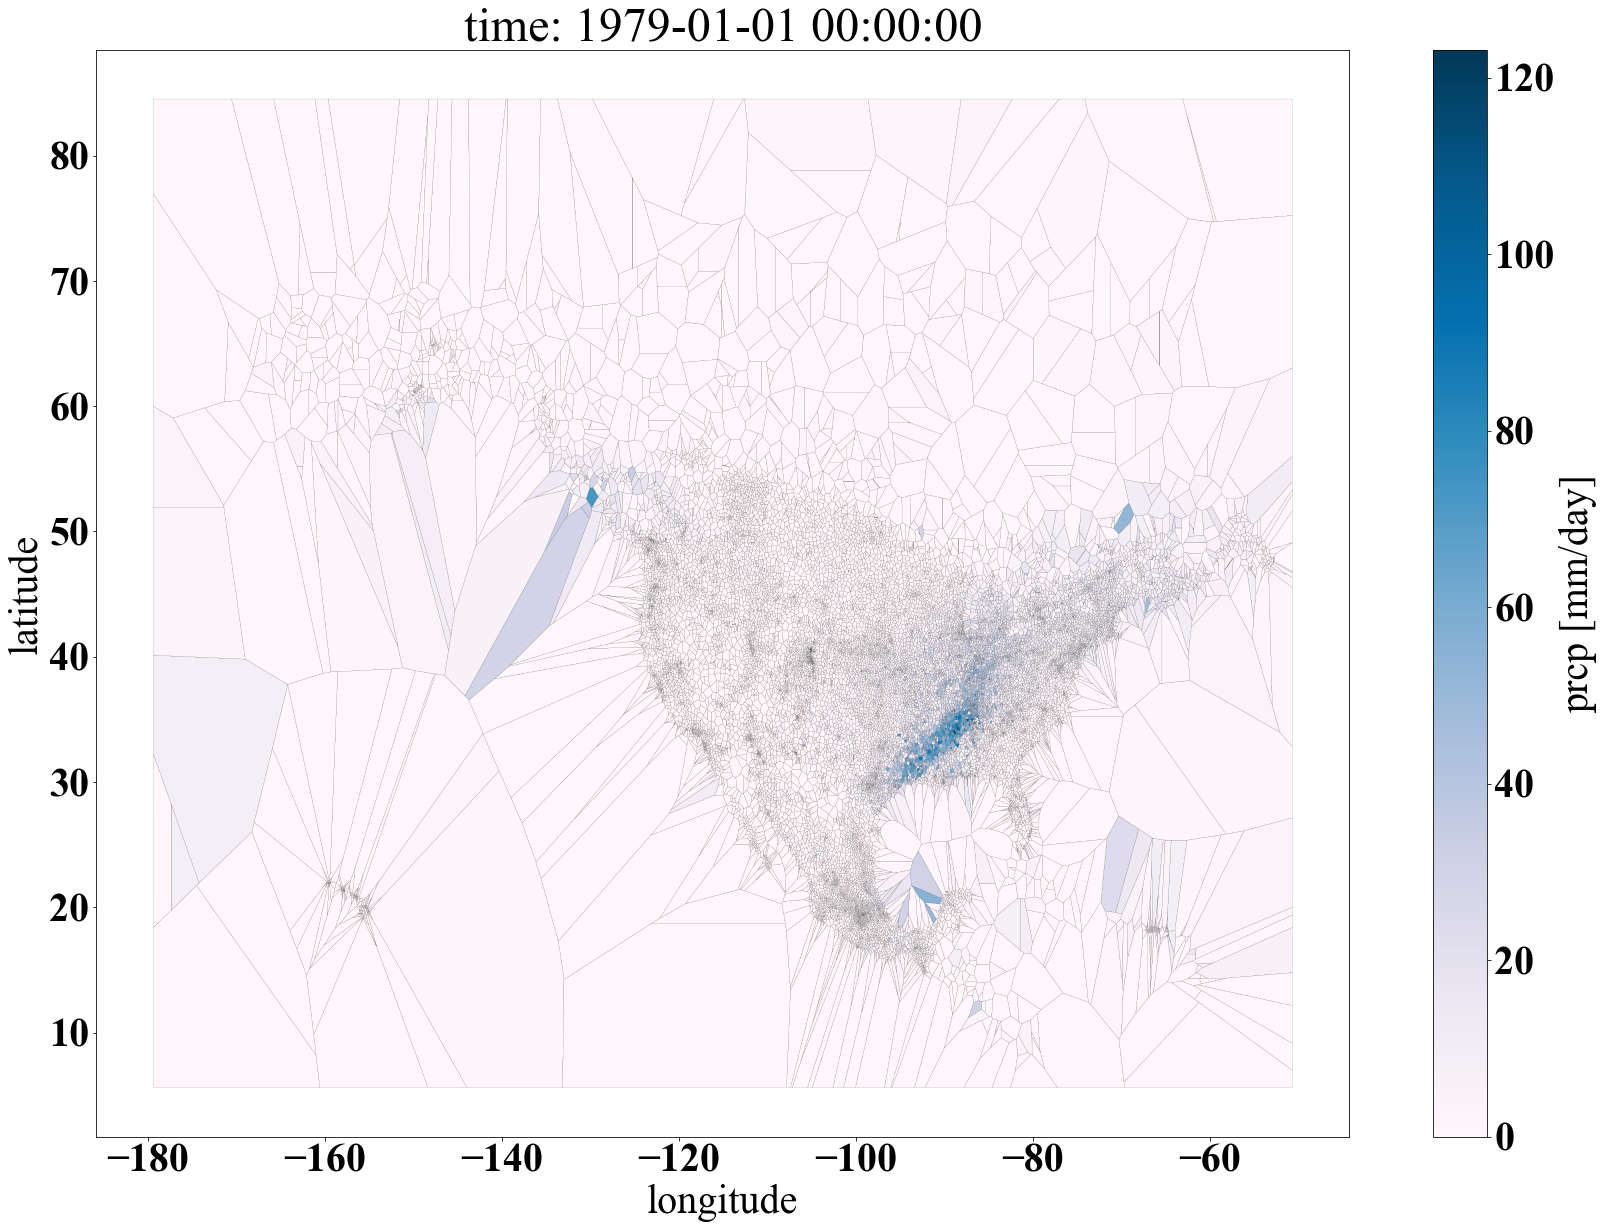

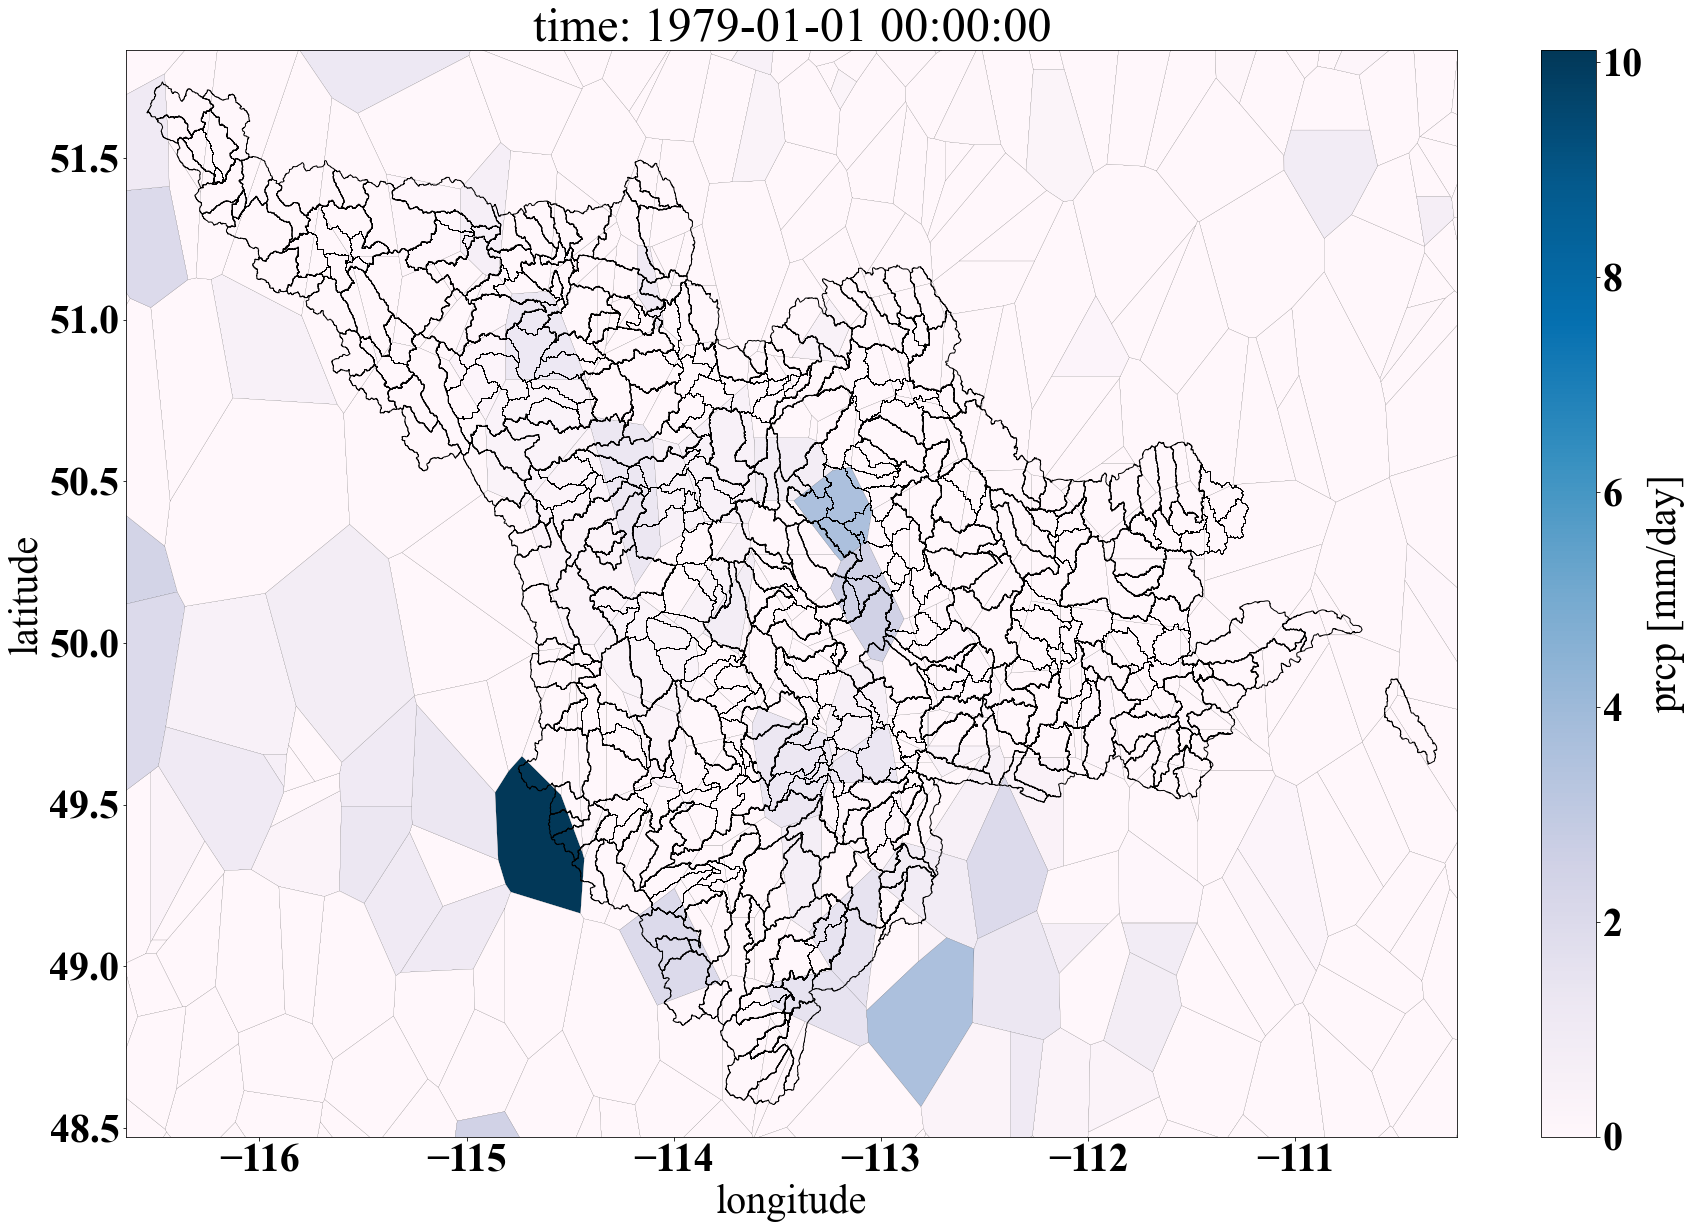

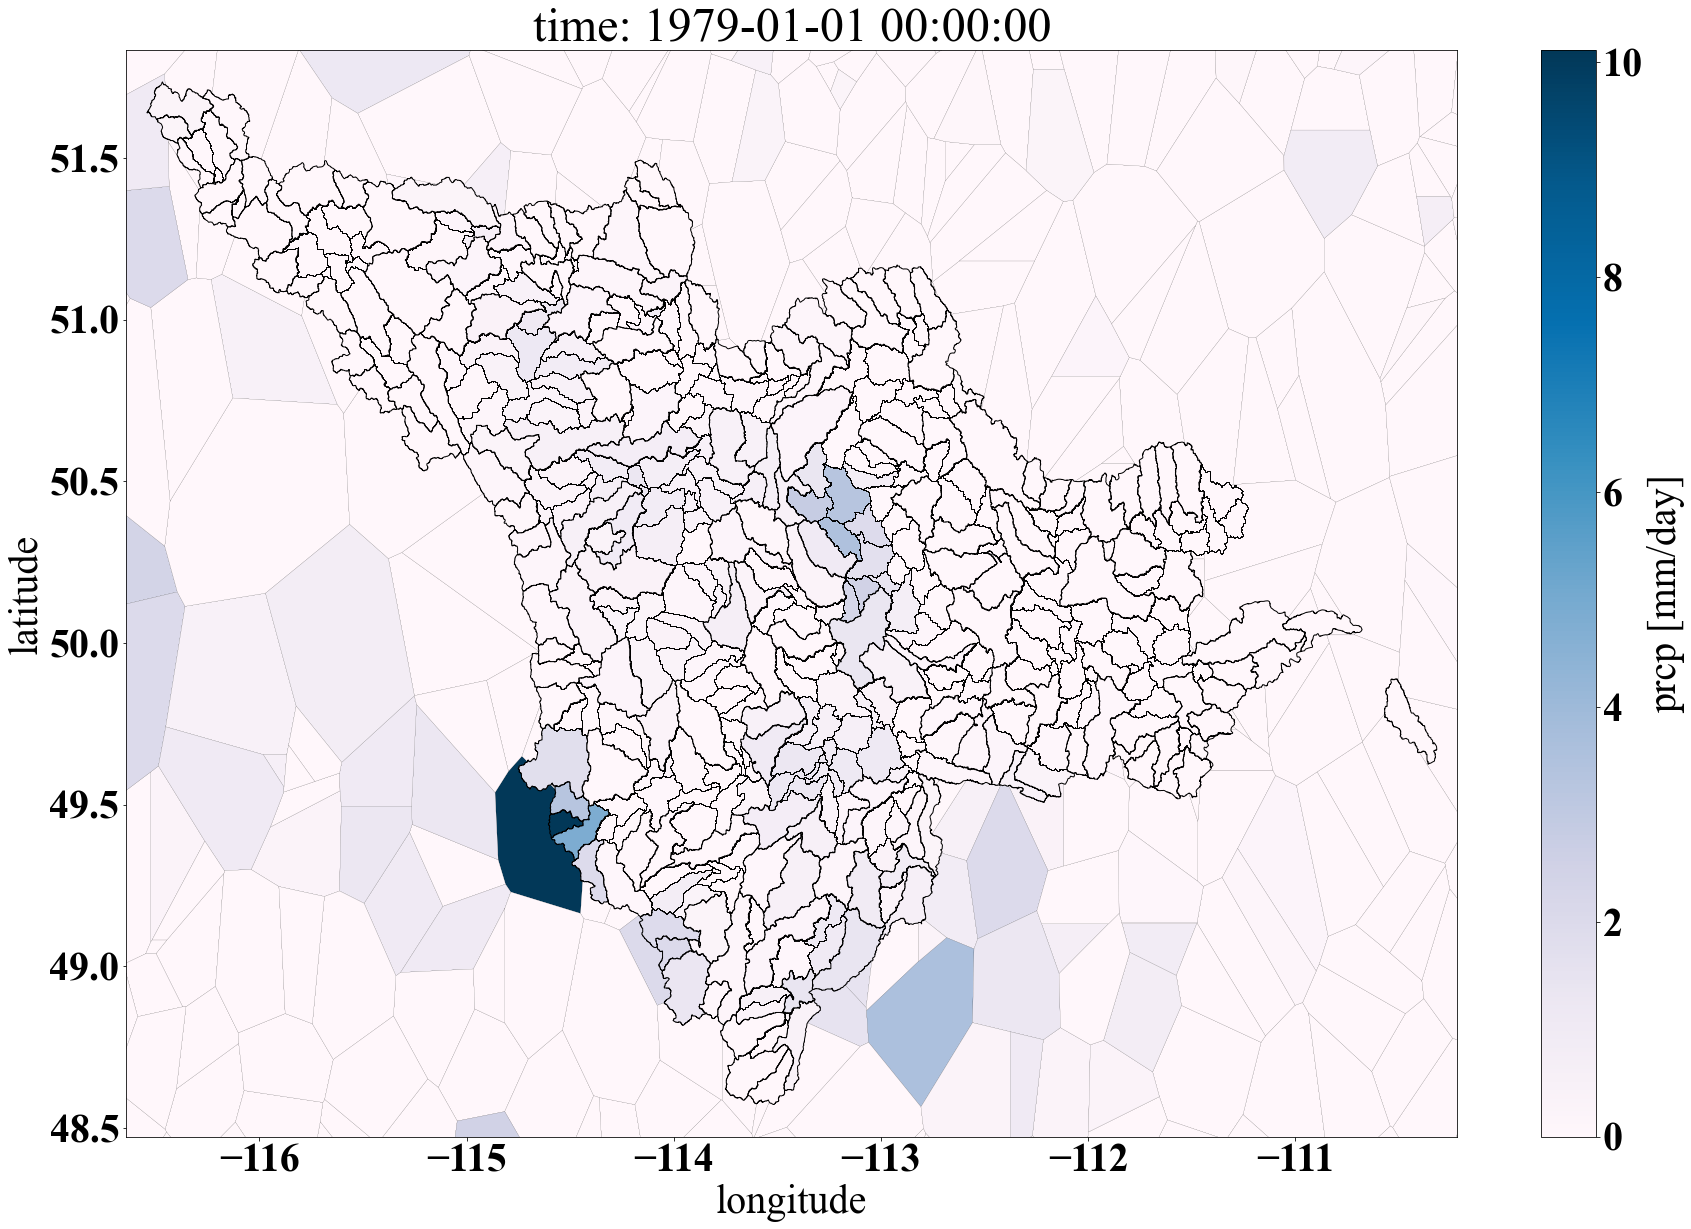

In [3]:
# loading EASYMORE
from easymore.easymore import easymore

# initializing EASYMORE object
esmr = easymore()

# set the paramaters
source_nc_name                  = './temporary/SCDNA/SCDNA_v1.1_prcp_1979.nc' # name of source nc file
source_nc_var_lon               = "Longitude" # lon in the source nc file
source_nc_var_lat               = "Latitude" # lat in the source nc file
source_nc_var_ID                = "ID" # ID in the source nc file
source_nc_var_time              = 'time' # variable time in the source nc file
source_nc_var_name              = 'prcp'# variable from the source nc file
source_shp_name                 = './temporary/SCDNA_Medicine_Hat_prcp_source_shapefile.shp' # source shapefile if case 3 such as station data; should be given or generated by EASYMORE
source_shp_field_ID             = "ID_s" # the ID of the source shapefile
shp_target_name                 = './data/target_shapefiles/South_Saskatchewan_MedicineHat.shp' # the target shapefile
shp_target_field_ID             = 'ID' # the field of the attribute that link the shapefile to remapped nc file
remapped_nc_name                = './output/SCDNA_Medicine_Hat_prcp_remapped_1979-01-01-00-00-00.nc' #'../output/ERA5_Medicine_Hat_remapped_1979-01-03-00-00-00.nc' # the remapped nc file
remapped_nc_var_ID              = "ID" # the ID from shapefile that match with remapped files
remapped_nc_var_time            = "time" # the varibale time in the nc file
remapped_nc_var_name            = 'prcp' # the variable name in the remapped file
time_step_of_viz                = '1979-01-01 00:00:00' # it should be in form of 1990-02-01 00:00:00 
folder_save_fig                 = './fig/' # location where the fig should be saved
fig_size                        = (30,20) # the figure size
cmap                            = 'PuBu' # the color 
linewidth_source                = 0.1 # linewidth for shapefile
linewidth_remapped              = 1 #
font_size                       = 40 # font size
font_family                     = 'Times New Roman' # name of the font type
font_weigth                     = 'bold' # to be bold
add_colorbar_flag               = True # flag to add colorbar
min_lon,min_lat,max_lon,max_lat = None, None, None, None # if there is lat/lon to zoom in

# the source nc file
esmr.nc_vis(source_nc_name             = source_nc_name,
            source_nc_var_lon          = source_nc_var_lon,
            source_nc_var_lat          = source_nc_var_lat,
            source_nc_var_ID           = source_nc_var_ID,
            source_nc_var_time         = source_nc_var_time,
            source_nc_var_name         = source_nc_var_name,
            source_shp_name            = source_shp_name,              
            source_shp_field_ID        = source_shp_field_ID,
            linewidth_source           = linewidth_source,
            time_step_of_viz           = time_step_of_viz,
            location_save_fig          = folder_save_fig,
            fig_name                   = 'E4_1.png',
            cmap                       = cmap,
            add_colorbar_flag          = add_colorbar_flag,
            font_size                  = font_size,
            fig_size                   = fig_size)

# the source nc file zoom to target shapefile without showing the remapped variables
esmr.nc_vis(source_nc_name             = source_nc_name,
            source_nc_var_lon          = source_nc_var_lon,
            source_nc_var_lat          = source_nc_var_lat,
            source_nc_var_ID           = source_nc_var_ID,
            source_nc_var_time         = source_nc_var_time,
            source_nc_var_name         = source_nc_var_name,
            source_shp_name            = source_shp_name,              
            source_shp_field_ID        = source_shp_field_ID,
            shp_target_name            = shp_target_name,
            shp_target_field_ID        = shp_target_field_ID,
            remapped_nc_name           = remapped_nc_name,
            remapped_nc_var_ID         = remapped_nc_var_ID,
            remapped_nc_var_time       = remapped_nc_var_time,
            remapped_nc_var_name       = remapped_nc_var_name,
            linewidth_source           = linewidth_source,
            linewidth_remapped         = linewidth_remapped,
            time_step_of_viz           = time_step_of_viz,
            location_save_fig          = folder_save_fig,
            show_target_shp_flag       = True,
            fig_name                   = 'E4_2.png',
            cmap                       = cmap,
            alpha_source               = 1.0,
            add_colorbar_flag          = add_colorbar_flag,
            font_size                  = font_size,
            fig_size                   = fig_size)


# the source nc file zoom to target shapefile with showing the remapped variables
esmr.nc_vis(source_nc_name             = source_nc_name,
            source_nc_var_lon          = source_nc_var_lon,
            source_nc_var_lat          = source_nc_var_lat,
            source_nc_var_ID           = source_nc_var_ID,
            source_nc_var_time         = source_nc_var_time,
            source_nc_var_name         = source_nc_var_name,
            source_shp_name            = source_shp_name,              
            source_shp_field_ID        = source_shp_field_ID,
            shp_target_name            = shp_target_name,
            shp_target_field_ID        = shp_target_field_ID,
            remapped_nc_name           = remapped_nc_name,
            remapped_nc_var_ID         = remapped_nc_var_ID,
            remapped_nc_var_time       = remapped_nc_var_time,
            remapped_nc_var_name       = remapped_nc_var_name,
            linewidth_source           = linewidth_source,
            linewidth_remapped         = linewidth_remapped,
            time_step_of_viz           = time_step_of_viz,
            location_save_fig          = folder_save_fig,
            show_target_shp_flag       = True,
            show_remapped_values_flag  = True,
            fig_name                   = 'E4_3.png',
            cmap                       = cmap,
            alpha_source               = 1.0,
            add_colorbar_flag          = add_colorbar_flag,
            font_size                  = font_size,
            fig_size                   = fig_size)





In [4]:
# merge the two figures into one
from PIL import Image, ImageFont, ImageDraw
image_list = ['fig/E4_2.png','fig/E4_3.png']
if image_list:
    images = [Image.open(x) for x in image_list]
    widths, heights = zip(*(i.size for i in images))
    total_width = sum(widths)
    max_height = max(heights)
    new_im = Image.new('RGB', (total_width, max_height))
    x_offset = 0
    for im in images:
        new_im.paste(im, (x_offset,0))
        x_offset += im.size[0]
    new_im.save(folder_save_fig+'E4_merged.png')
    